# Autoencoders - Tutorial 1

This notebooks aims to explore the autoencoders, in particular, variational autoencoders and the posibility to generate images.

This images will:

 - Generate an MLP based and a CNN based autoencoder, to then qualitatively compare the images generated.
 - Define a Variational Autoencoder to generate images.
 - Experiment with the embedding dimension for the image generation task
 
 ----

In [1]:
# imports
import os
import time
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid

%matplotlib inline

torch.manual_seed(42)
np.random.seed(42)

# Load Data

In [2]:
# define pre-processing image transformation and respective inverse back-transform
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to torch tensor
    transforms.Normalize([0.5], [0.5])  # normalize image
])

def back_transform(x:torch.Tensor):
    """Transforms model output back to original image space."""
    x = 0.5 * (x + 1)   # revert normalization
    x = x.clamp(0, 1)   # threshold
    x = x.view(x.size(0), 1, 28, 28)    # reshape
    return x

In [3]:
# load data (will download if it is not found locally) and apply defined transformations
train_ds = MNIST('./data', download=True, transform=transform)
test_ds = MNIST('./data', download=True, train=False, transform=transform)

In [4]:
#Dataset information
print(f"Train instances: {len(train_ds)}")
print(f"Test instances: {len(test_ds)}\n")
print(f"Input shape: {train_ds[0][0].shape}")
print(f"Output type: {type(train_ds[0][1])}, (Not needed for autoencoder)")

Train instances: 60000
Test instances: 10000

Input shape: torch.Size([1, 28, 28])
Output type: <class 'int'>, (Not needed for autoencoder)


# Define MLP autoencoder

In [5]:
class AutoEncoder(nn.Module):
    """Abstract AE class."""
    def __init__(self, preprocess_callbacks=(), loss_fn=F.mse_loss):
        super().__init__()
        self.encoder = None
        self.decoder = None
        self.preprocess_cb = preprocess_callbacks
        self.loss_fn = loss_fn

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def fit(self,
            dataset:torch.utils.data.dataset,
            num_epochs:int=102,
            batch_size:int=32,
            lr:float=1e-3,
            sample_epoch:int=10,
            device:str='cuda:0',
            ):
        """Train model on provided dataset."""

        # create directory to save sample images
        tstamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        pth = f"./samples/{self.__class__.__name__}/run_{tstamp}/"
        os.makedirs(pth)#, exist_ok=True)

        # device management (CPU/GPU)
        device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.to(device)
        print(f"running on {device}.")

        # optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)

        # batch data loader
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # training loop
        print("starting training...")
        self.train()
        start_time = time.time()
        for epoch in range(num_epochs):
            ep_loss = []
            for data in dataloader:

                img, _ = data   # only need img, no label
                for prep in self.preprocess_cb:
                    img = prep(img)
                img = img.to(device)  # transfer to GPU if specified

                # forward pass
                out = self(img)
                # calc loss
                loss = self.loss_fn(out, img)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                ep_loss.append(loss.mean().cpu().item())

            # epoch log
            t = time.time()-start_time
            print(f"{time.strftime('%H:%M:%S', time.gmtime(t))} - "
                  f"Epoch: {epoch+1}/{num_epochs}, "
                  f"loss: {np.mean(ep_loss):.6f}")

            # save reconstructed image samples
            if epoch % sample_epoch == 0:
                rec_img = back_transform(out.cpu())
                save_image(rec_img, f"{pth}image_eps{epoch}.png")


In [6]:
class PrintLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x.shape)
        return x

In [7]:
def flatten(x):
    """Flatten image input."""
    return x.view(x.size(0), -1)

In [13]:
# define simple FC model
class SimpleAutoEncoder(AutoEncoder):
    """Simple AE."""
    def __init__(self):
        super().__init__(preprocess_callbacks=[flatten])
        # fully connected encoder model
        self.encoder = nn.Sequential(nn.Linear(784, 256),
                                      nn.ReLU(),
                                      nn.Linear(256, 64),
                                      nn.ReLU(),
                                      nn.Linear(64, 20),
                                      nn.ReLU()
        )
        # fully connected decoder model
        self.decoder = nn.Sequential(nn.Linear(20, 64),
                                      nn.ReLU(),
                                      nn.Linear(64, 256),
                                      nn.ReLU(),
                                      nn.Linear(256, 784),
                                      nn.Sigmoid()
        )

# Train MLP autoencoder and visualize reconstructed images

In [ ]:
# create model and train
model = SimpleAutoEncoder()
model.fit(train_ds)

running on cuda:0.
starting training...
00:00:12 - Epoch: 1/102, loss: 0.930324
00:00:24 - Epoch: 2/102, loss: 0.925375
00:00:35 - Epoch: 3/102, loss: 0.925373
00:00:46 - Epoch: 4/102, loss: 0.925375
00:00:59 - Epoch: 5/102, loss: 0.925382
00:01:10 - Epoch: 6/102, loss: 0.925398
00:01:21 - Epoch: 7/102, loss: 0.925371
00:01:32 - Epoch: 8/102, loss: 0.925371
00:01:43 - Epoch: 9/102, loss: 0.926183
00:01:54 - Epoch: 10/102, loss: 0.925526
00:02:05 - Epoch: 11/102, loss: 0.916202
00:02:16 - Epoch: 12/102, loss: 0.908057
00:02:27 - Epoch: 13/102, loss: 0.903335
00:02:38 - Epoch: 14/102, loss: 0.901440
00:02:49 - Epoch: 15/102, loss: 0.900087
00:03:00 - Epoch: 16/102, loss: 0.897914
00:03:11 - Epoch: 17/102, loss: 0.896125
00:03:22 - Epoch: 18/102, loss: 0.895220
00:03:33 - Epoch: 19/102, loss: 0.894631
00:03:44 - Epoch: 20/102, loss: 0.893932
00:03:54 - Epoch: 21/102, loss: 0.892527
00:04:05 - Epoch: 22/102, loss: 0.891343
00:04:17 - Epoch: 23/102, loss: 0.890369
00:04:28 - Epoch: 24/102, 

Text(0.5, 1.0, '100 epochs')

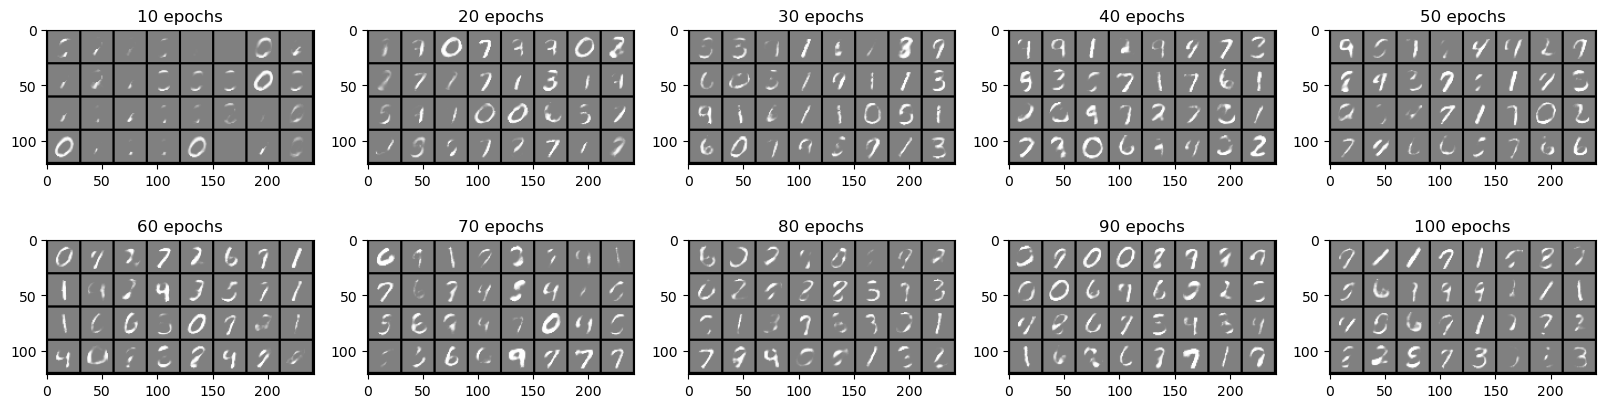

In [21]:
path = "samples/SimpleAutoEncoder/run_2023-07-13_15-58-47/"
im_0 = img.imread(path+"image_eps0.png")
im_1 = img.imread(path+"image_eps10.png")
im_2 = img.imread(path+"image_eps20.png")
im_3 = img.imread(path+"image_eps30.png")
im_4 = img.imread(path+"image_eps40.png")
im_5 = img.imread(path+"image_eps50.png")
im_6 = img.imread(path+"image_eps60.png")
im_7 = img.imread(path+"image_eps70.png")
im_8 = img.imread(path+"image_eps80.png")
im_9 = img.imread(path+"image_eps90.png")
im_10 = img.imread(path+"image_eps100.png")


fig, axs = plt.subplots(2, 5, figsize=(20,5))
axs[0,0].imshow(im_1)
axs[0,0].set_title('10 epochs')

axs[0,1].imshow(im_2)
axs[0,1].set_title('20 epochs')

axs[0,2].imshow(im_3)
axs[0,2].set_title('30 epochs')

axs[0,3].imshow(im_4)
axs[0,3].set_title('40 epochs')

axs[0,4].imshow(im_5)
axs[0,4].set_title('50 epochs')

axs[1,0].imshow(im_6)
axs[1,0].set_title('60 epochs')

axs[1,1].imshow(im_7)
axs[1,1].set_title('70 epochs')

axs[1,2].imshow(im_8)
axs[1,2].set_title('80 epochs')

axs[1,3].imshow(im_9)
axs[1,3].set_title('90 epochs')

axs[1,4].imshow(im_10)
axs[1,4].set_title('100 epochs')

# Define Convolutional Autoencoder

In [22]:
# Conv Autoencoder
class ConvAutoEncoder(AutoEncoder):
    """AE"""
    def __init__(self):
        super().__init__()
        #Encoder
        self.encoder = nn.Sequential(nn.Conv2d(1, 8, 2, stride=2),
                                      nn.ReLU(),
                                      nn.Conv2d(8, 16, 2, stride=2),
                                      nn.ReLU(),
                                      nn.Conv2d(16, 32, 3, stride=2),
                                      nn.ReLU(),
                                      nn.Flatten(),
                                      nn.Linear(288, 20),
                                      nn.ReLU()
        )
        #Decoder
        self.decoder = nn.Sequential(nn.Linear(20, 288),
                                      nn.ReLU(),
                                      nn.Unflatten(1,[32,3,3]),
                                      nn.ConvTranspose2d(32, 16, 3, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(16, 8, 2, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(8, 1, 2, stride=2),
                                      nn.Sigmoid()
        )

# Train CNN autoencoder and visualize reconstructed images

In [23]:
# create model and train
model = ConvAutoEncoder()
model.fit(train_ds)#, lr=1e-4)

running on cuda:0.
starting training...
00:00:12 - Epoch: 1/102, loss: 0.944491
00:00:23 - Epoch: 2/102, loss: 0.925370
00:00:34 - Epoch: 3/102, loss: 0.925012
00:00:44 - Epoch: 4/102, loss: 0.917902
00:00:54 - Epoch: 5/102, loss: 0.914038
00:01:04 - Epoch: 6/102, loss: 0.906481
00:01:15 - Epoch: 7/102, loss: 0.891754
00:01:25 - Epoch: 8/102, loss: 0.884513
00:01:35 - Epoch: 9/102, loss: 0.882350
00:01:45 - Epoch: 10/102, loss: 0.881088
00:01:55 - Epoch: 11/102, loss: 0.880274
00:02:05 - Epoch: 12/102, loss: 0.879696
00:02:15 - Epoch: 13/102, loss: 0.879180
00:02:26 - Epoch: 14/102, loss: 0.878795
00:02:36 - Epoch: 15/102, loss: 0.870567
00:02:47 - Epoch: 16/102, loss: 0.867414
00:02:57 - Epoch: 17/102, loss: 0.866453
00:03:06 - Epoch: 18/102, loss: 0.865723
00:03:16 - Epoch: 19/102, loss: 0.865154
00:03:26 - Epoch: 20/102, loss: 0.864742
00:03:36 - Epoch: 21/102, loss: 0.864361
00:03:45 - Epoch: 22/102, loss: 0.864054
00:03:55 - Epoch: 23/102, loss: 0.863782
00:04:05 - Epoch: 24/102, 

Text(0.5, 1.0, '100 epochs')

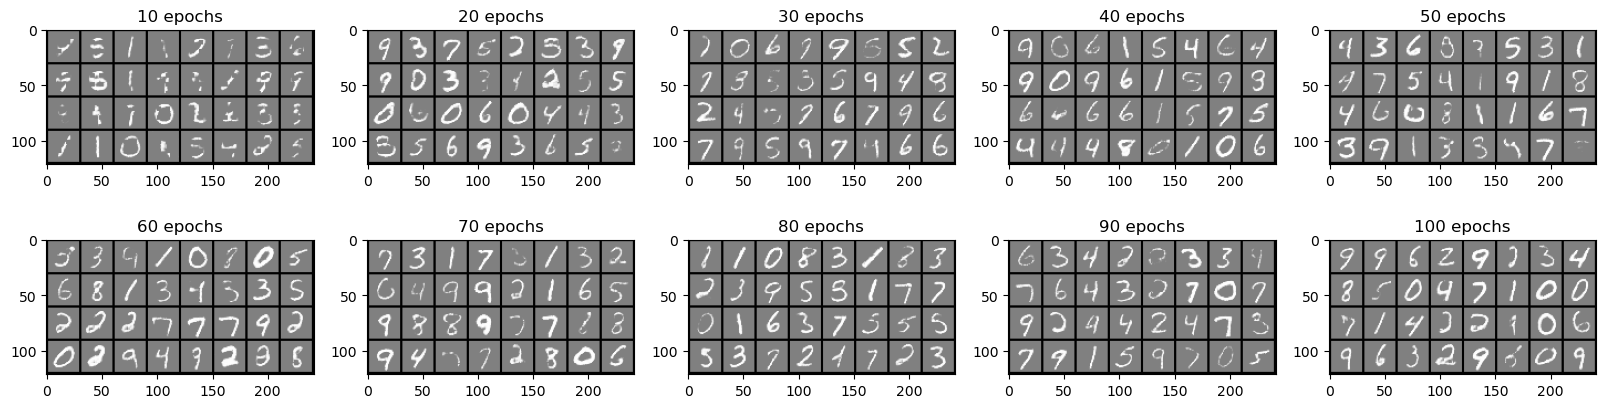

In [24]:
path = "samples/ConvAutoEncoder/run_2023-07-13_16-20-36/"
#im_0 = img.imread(path+"image_eps0.png")
im_1 = img.imread(path+"image_eps10.png")
im_2 = img.imread(path+"image_eps20.png")
im_3 = img.imread(path+"image_eps30.png")
im_4 = img.imread(path+"image_eps40.png")
im_5 = img.imread(path+"image_eps50.png")
im_6 = img.imread(path+"image_eps60.png")
im_7 = img.imread(path+"image_eps70.png")
im_8 = img.imread(path+"image_eps80.png")
im_9 = img.imread(path+"image_eps90.png")
im_10 = img.imread(path+"image_eps100.png")


fig, axs = plt.subplots(2, 5, figsize=(20,5))
axs[0,0].imshow(im_1)
axs[0,0].set_title('10 epochs')

axs[0,1].imshow(im_2)
axs[0,1].set_title('20 epochs')

axs[0,2].imshow(im_3)
axs[0,2].set_title('30 epochs')

axs[0,3].imshow(im_4)
axs[0,3].set_title('40 epochs')

axs[0,4].imshow(im_5)
axs[0,4].set_title('50 epochs')

axs[1,0].imshow(im_6)
axs[1,0].set_title('60 epochs')

axs[1,1].imshow(im_7)
axs[1,1].set_title('70 epochs')

axs[1,2].imshow(im_8)
axs[1,2].set_title('80 epochs')

axs[1,3].imshow(im_9)
axs[1,3].set_title('90 epochs')

axs[1,4].imshow(im_10)
axs[1,4].set_title('100 epochs')

### Conclusions

Doing a qualitative comparison, CNN have a better performance for the autoencoder tasks. This alings with the fact that CNN are architectures specialized in Computer Vision, i.e., they are much better suited for the image domain.  

# Define Variational Autoencoder

In [36]:
class VEncoder(nn.Module):
    """Encoder model for VAE."""
    def __init__(self, emb_dim:int=20):
        super().__init__()
        self.emb_dim = emb_dim

        self.enc_ff = nn.Sequential(nn.Conv2d(1, 8, 2, stride=2),
                                      nn.ReLU(),
                                      nn.Conv2d(8, 16, 2, stride=2),
                                      nn.ReLU(),
                                      nn.Conv2d(16, 32, 3, stride=2),
                                      nn.ReLU(),
                                      nn.Flatten()
        )

        self.enc_mu = nn.Linear(288, emb_dim)
        self.enc_sigma = nn.Sequential(nn.Linear(288, emb_dim))

    def forward(self, x):
        """Forward to output the latent vectors mu and sigma
        which parameterize the Gaussian from which we
        sample the latent embedding z"""
        h = F.relu(self.enc_ff(x))
        return self.enc_mu(h), self.enc_sigma(h)


class VDecoder(nn.Module):
    """Decoder model for VAE."""
    def __init__(self, emb_dim:int=20):
        super().__init__()
        self.emb_dim = emb_dim

        self.dec = nn.Sequential(nn.Linear(emb_dim, 288),
                                      nn.ReLU(),
                                      nn.Unflatten(1,[32,3,3]),
                                      nn.ConvTranspose2d(32, 16, 3, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(16, 8, 2, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(8, 1, 2, stride=2),
                                      nn.Sigmoid()
        )

    def forward(self, x):
        """Forward to decode the latent embedding z"""
        return self.dec(x)


class VAE(nn.Module):
    """AE with variational inference."""
    def __init__(self, emb_dim:int=20, preprocess_callbacks=()):
        super().__init__()
        self.emb_dim = emb_dim
        self.encoder = VEncoder(emb_dim=emb_dim)
        self.decoder = VDecoder(emb_dim=emb_dim)
        self.preprocess_cb = preprocess_callbacks
        
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.device = device

    def reparameterize(self, mu, log_sigma):
        """Implements the re-parameterization trick."""

        size = list(mu.size())
        eps = z = torch.randn(size=size, device=self.device)
        z = mu + eps*(np.e**log_sigma)
        return z

    def forward(self, x):
        mu, log_sigma = self.encoder(x)
        z = self.reparameterize(mu, log_sigma)
        return self.decoder(z), mu, log_sigma

    def loss_fn(self, rec_x, x, mu, log_sigma):
        """Adapted loss function consisting of binary cross entropy (reconstruction of image)
        and Kullback-Leibler divergence"""
        bce = F.binary_cross_entropy(rec_x, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp())
        return bce + kld

    def fit(self,
            dataset:torch.utils.data.dataset,
            num_epochs:int=101,
            batch_size:int=32,
            lr:float=1e-4,
            sample_epoch:int=10,
            ):
        """Train model on provided dataset."""

        # create directory to save sample images
        tstamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        pth = f"./samples/{self.__class__.__name__}/run_{tstamp}/"
        os.makedirs(pth, exist_ok=True)

        # device management (CPU/GPU)
        self.to(self.device)
        print(f"running on {self.device}.")

        # optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)

        # batch data loader
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # training loop
        print("starting training...")
        self.train()
        start_time = time.time()
        for epoch in range(num_epochs):
            ep_loss = []
            for data in dataloader:


                img, _ = data   # only need img, no label
                for prep in self.preprocess_cb:
                    img = prep(img)
                img = img.to(self.device)  # transfer to GPU if specified

                # forward pass
                out, mu, log_sigma = self(img)
                # calc loss
                loss = self.loss_fn(out, img, mu, log_sigma)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                ep_loss.append(loss.cpu().item())

            # epoch log
            t = time.time()-start_time
            print(f"{time.strftime('%H:%M:%S', time.gmtime(t))} - "
                  f"Epoch: {epoch+1}/{num_epochs}, "
                  f"loss: {np.mean(ep_loss):.6f}")

            # save reconstructed image samples
            if epoch % sample_epoch == 0:
                rec_img = out.cpu().view(out.size(0), 1, 28, 28)    # reshape to MNIST image dims
                save_image(rec_img, f"{pth}image_eps{epoch}.png")

    def generate(self,
                 size:int=1,
                 ):
        """Generate new images with the trained model."""
        self.eval()
        with torch.no_grad():
            z = torch.randn(size=(size, self.emb_dim), device=self.device)  # sample from std normal
            img_out = self.decoder(z).cpu()
        return img_out #img_out.view(img_out.size(0), 1, 28, 28)     # reshape to MNIST image dims

#     def generate2(self,
#                  size:int=1,
#                  device:str='cuda:0',
#                  ):
#         """Generate new images with the trained model."""
#         self.eval()
#         device = torch.device(device if torch.cuda.is_available() else 'cpu')
#         dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
#         for data in dataloader:
#           img, _ = data
#           img = img.to(device)
#           mu, log_sigma = self.encoder(img)
#           with torch.no_grad():
#               eps = torch.randn(size=(size, self.emb_dim), device=device)  # sample from std normal
#               img_out = self.decoder(mu+eps).cpu()
#           return img_out #img_out.view(img_out.size(0), 1, 28, 28)     # reshape to MNIST image dims

#     def generate3(self,
#                  size:int=1,
#                  device:str='cuda:0',
#                  ):
#         """Generate new images with the trained model."""
#         self.eval()
#         device = torch.device(device if torch.cuda.is_available() else 'cpu')
#         dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
#         for data in dataloader:
#           img, _ = data
#           img = img.to(device)
#           mu, log_sigma = self.encoder(img)
#           with torch.no_grad():
#               eps = torch.randn(size=(size, self.emb_dim), device=device)  # sample from std normal
#               img_out = self.decoder(mu+eps*(np.e**log_sigma)).cpu()
#           return img_out #img_out.view(img_out.size(0), 1, 28, 28)     # reshape to MNIST image dims


# Train Variational Autoencoder and visualize reconstructed images

In [40]:
# create model and train
model = VAE()
model.fit(train_ds) #model.fit(dataset)

running on cuda:0.
starting training...
00:00:11 - Epoch: 1/101, loss: -1301954.568646
00:00:22 - Epoch: 2/101, loss: -1591666.755733
00:00:34 - Epoch: 3/101, loss: -1754377.215600
00:00:46 - Epoch: 4/101, loss: -1840770.939067
00:00:57 - Epoch: 5/101, loss: -1869628.691867
00:01:10 - Epoch: 6/101, loss: -1891460.887200
00:01:21 - Epoch: 7/101, loss: -1904310.969667
00:01:34 - Epoch: 8/101, loss: -1912121.315667
00:01:45 - Epoch: 9/101, loss: -1920758.614800
00:01:56 - Epoch: 10/101, loss: -1928138.970267
00:02:08 - Epoch: 11/101, loss: -1932479.196267
00:02:21 - Epoch: 12/101, loss: -1935129.522000
00:02:33 - Epoch: 13/101, loss: -1937941.651600
00:02:45 - Epoch: 14/101, loss: -1940662.308333
00:02:58 - Epoch: 15/101, loss: -1941682.366067
00:03:10 - Epoch: 16/101, loss: -1940879.345267
00:03:22 - Epoch: 17/101, loss: -1940106.087800
00:03:33 - Epoch: 18/101, loss: -1940123.529267
00:03:45 - Epoch: 19/101, loss: -1940124.821667
00:03:58 - Epoch: 20/101, loss: -1973421.494533
00:04:10 

Text(0.5, 1.0, '100 epochs')

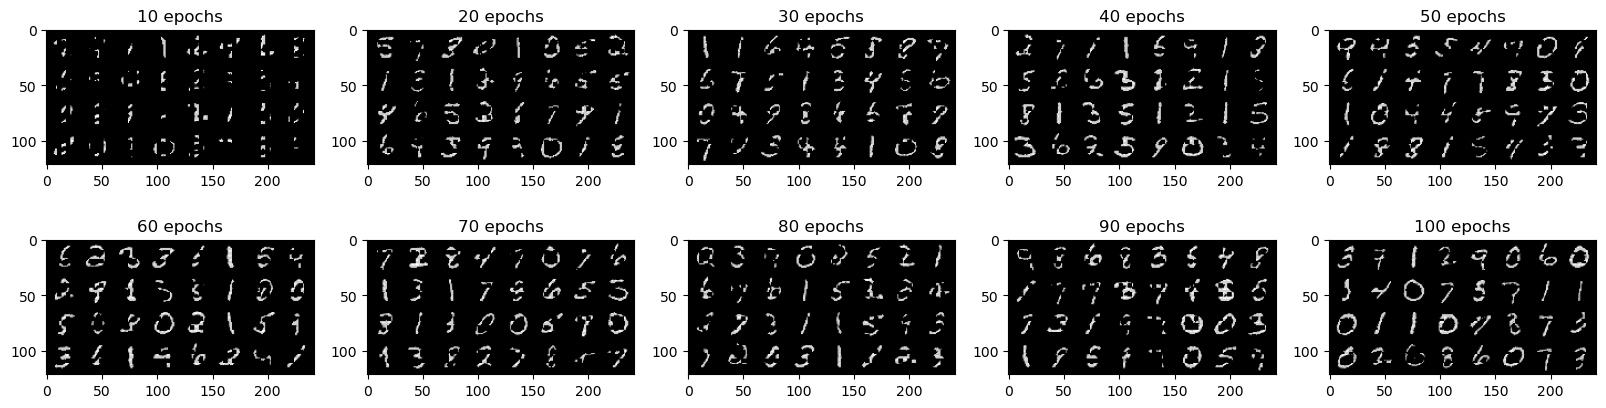

In [44]:
path = "samples/VAE/run_2023-07-13_16-45-25/"
#im_0 = img.imread(path+"image_eps0.png")
im_1 = img.imread(path+"image_eps10.png")
im_2 = img.imread(path+"image_eps20.png")
im_3 = img.imread(path+"image_eps30.png")
im_4 = img.imread(path+"image_eps40.png")
im_5 = img.imread(path+"image_eps50.png")
im_6 = img.imread(path+"image_eps60.png")
im_7 = img.imread(path+"image_eps70.png")
im_8 = img.imread(path+"image_eps80.png")
im_9 = img.imread(path+"image_eps90.png")
im_10 = img.imread(path+"image_eps100.png")


fig, axs = plt.subplots(2, 5, figsize=(20,5))
axs[0,0].imshow(im_1)
axs[0,0].set_title('10 epochs')

axs[0,1].imshow(im_2)
axs[0,1].set_title('20 epochs')

axs[0,2].imshow(im_3)
axs[0,2].set_title('30 epochs')

axs[0,3].imshow(im_4)
axs[0,3].set_title('40 epochs')

axs[0,4].imshow(im_5)
axs[0,4].set_title('50 epochs')

axs[1,0].imshow(im_6)
axs[1,0].set_title('60 epochs')

axs[1,1].imshow(im_7)
axs[1,1].set_title('70 epochs')

axs[1,2].imshow(im_8)
axs[1,2].set_title('80 epochs')

axs[1,3].imshow(im_9)
axs[1,3].set_title('90 epochs')

axs[1,4].imshow(im_10)
axs[1,4].set_title('100 epochs')

# Use the VAE model to generate new images

This is done by sampling from a N(0,1) Gaussian distribution from the embedding space to then pass it through the decoder.

In [9]:
def show_img(img_out):
    """Plot a number of MNIST sample images."""
    nrow = int(np.ceil(np.sqrt(img_out.size(0))))
    grid = make_grid(img_out, nrow=nrow)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    # convert to numpy array
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    # plot
    plt.clf()
    plt.imshow(ndarr, cmap='gray')
    plt.show()

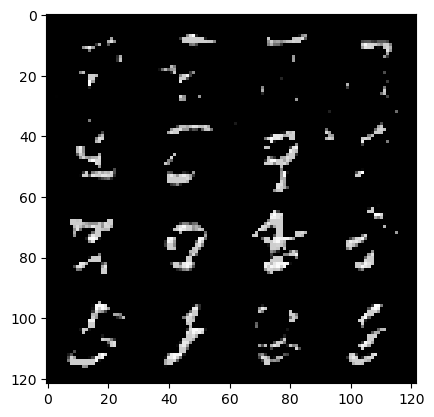

In [53]:
# create some samples from random noise and show them
samples = model.generate(16)
show_img(samples)

# Experiment with different Embedding sizes

In [37]:
# create model and train
model2 = VAE(emb_dim=10)
model2.fit(train_ds)

running on cuda:0.
starting training...
00:00:13 - Epoch: 1/101, loss: -1332183.234872
00:00:26 - Epoch: 2/101, loss: -1661788.031067
00:00:40 - Epoch: 3/101, loss: -1280557.165367
00:00:54 - Epoch: 4/101, loss: -1001129.665767
00:01:09 - Epoch: 5/101, loss: -1119868.923133
00:01:23 - Epoch: 6/101, loss: -1249787.364967
00:01:38 - Epoch: 7/101, loss: -1567181.473333
00:01:51 - Epoch: 8/101, loss: -1674789.491933
00:02:06 - Epoch: 9/101, loss: -1744232.056533
00:02:20 - Epoch: 10/101, loss: -1772550.496067
00:02:34 - Epoch: 11/101, loss: -1789204.486133
00:02:48 - Epoch: 12/101, loss: -1816571.432267
00:03:02 - Epoch: 13/101, loss: -1842401.784333
00:03:16 - Epoch: 14/101, loss: -1856530.135933
00:03:30 - Epoch: 15/101, loss: -1858796.383933
00:03:43 - Epoch: 16/101, loss: -1858131.953467
00:03:56 - Epoch: 17/101, loss: -1860793.588533
00:04:09 - Epoch: 18/101, loss: -1866230.338333
00:04:22 - Epoch: 19/101, loss: -1872551.610400
00:04:35 - Epoch: 20/101, loss: -1878406.766800
00:04:47 

Text(0.5, 1.0, '100 epochs')

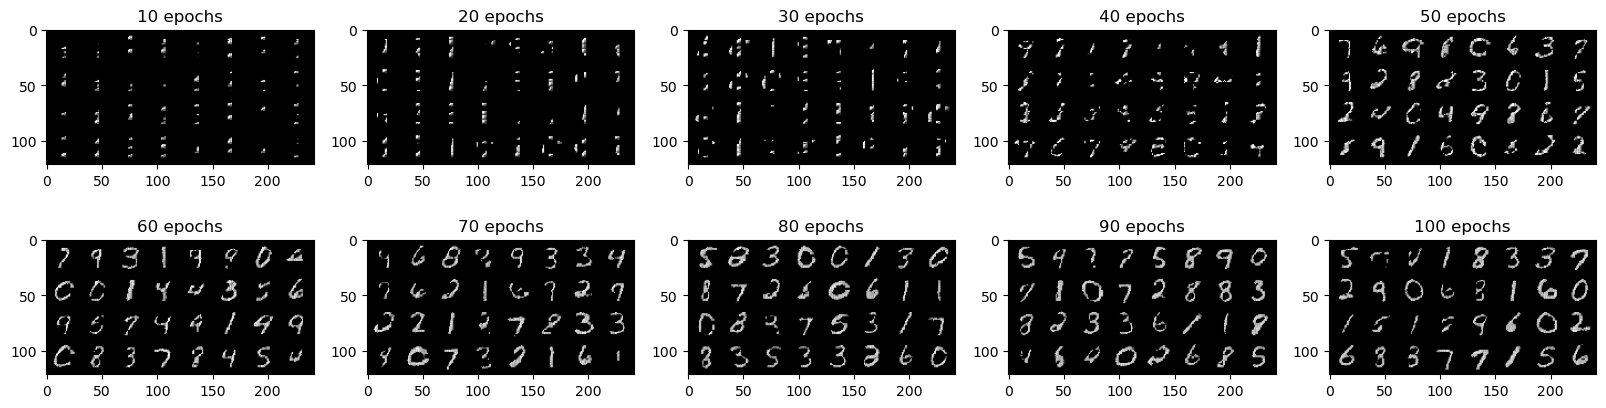

In [38]:
path = "samples/VAE/run_2023-07-13_20-42-05/"
#im_0 = img.imread(path+"image_eps0.png")
im_1 = img.imread(path+"image_eps10.png")
im_2 = img.imread(path+"image_eps20.png")
im_3 = img.imread(path+"image_eps30.png")
im_4 = img.imread(path+"image_eps40.png")
im_5 = img.imread(path+"image_eps50.png")
im_6 = img.imread(path+"image_eps60.png")
im_7 = img.imread(path+"image_eps70.png")
im_8 = img.imread(path+"image_eps80.png")
im_9 = img.imread(path+"image_eps90.png")
im_10 = img.imread(path+"image_eps100.png")


fig, axs = plt.subplots(2, 5, figsize=(20,5))
axs[0,0].imshow(im_1)
axs[0,0].set_title('10 epochs')

axs[0,1].imshow(im_2)
axs[0,1].set_title('20 epochs')

axs[0,2].imshow(im_3)
axs[0,2].set_title('30 epochs')

axs[0,3].imshow(im_4)
axs[0,3].set_title('40 epochs')

axs[0,4].imshow(im_5)
axs[0,4].set_title('50 epochs')

axs[1,0].imshow(im_6)
axs[1,0].set_title('60 epochs')

axs[1,1].imshow(im_7)
axs[1,1].set_title('70 epochs')

axs[1,2].imshow(im_8)
axs[1,2].set_title('80 epochs')

axs[1,3].imshow(im_9)
axs[1,3].set_title('90 epochs')

axs[1,4].imshow(im_10)
axs[1,4].set_title('100 epochs')

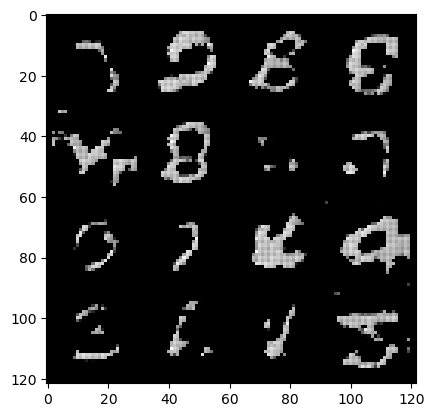

In [55]:
# create some samples from random noise and show them
samples = model2.generate(16)
show_img(samples)

In [40]:
# create model and train
model3 = VAE(emb_dim=5)
model3.fit(train_ds, lr=0.00001)

running on cuda:0.
starting training...
00:00:14 - Epoch: 1/101, loss: -1265619.087338
00:00:27 - Epoch: 2/101, loss: -1645537.786800
00:00:40 - Epoch: 3/101, loss: -1716592.236000
00:00:54 - Epoch: 4/101, loss: -1437143.816400
00:01:08 - Epoch: 5/101, loss: -990651.432267
00:01:22 - Epoch: 6/101, loss: -1148571.873400
00:01:35 - Epoch: 7/101, loss: -1448126.400133
00:01:49 - Epoch: 8/101, loss: -1608436.555800
00:02:03 - Epoch: 9/101, loss: -1693302.812800
00:02:17 - Epoch: 10/101, loss: -1729582.724200
00:02:30 - Epoch: 11/101, loss: -1759531.105133
00:02:44 - Epoch: 12/101, loss: -1770735.475267
00:02:58 - Epoch: 13/101, loss: -1791362.354333
00:03:12 - Epoch: 14/101, loss: -1821630.622400
00:03:26 - Epoch: 15/101, loss: -1839831.240200
00:03:41 - Epoch: 16/101, loss: -1849967.479400
00:03:55 - Epoch: 17/101, loss: -1856712.452867
00:04:08 - Epoch: 18/101, loss: -1861608.884533
00:04:21 - Epoch: 19/101, loss: -1866078.083267
00:04:35 - Epoch: 20/101, loss: -1869543.536800
00:04:48 -

Text(0.5, 1.0, '100 epochs')

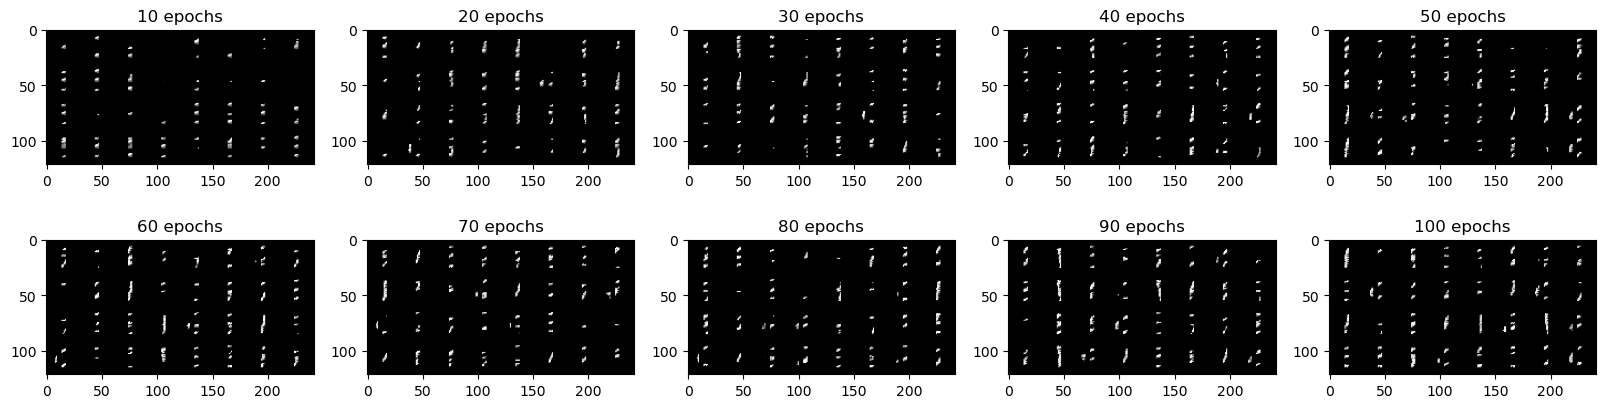

In [56]:
path = "samples/VAE/run_2023-07-13_21-04-03/"
#im_0 = img.imread(path+"image_eps0.png")
im_1 = img.imread(path+"image_eps10.png")
im_2 = img.imread(path+"image_eps20.png")
im_3 = img.imread(path+"image_eps30.png")
im_4 = img.imread(path+"image_eps40.png")
im_5 = img.imread(path+"image_eps50.png")
im_6 = img.imread(path+"image_eps60.png")
im_7 = img.imread(path+"image_eps70.png")
im_8 = img.imread(path+"image_eps80.png")
im_9 = img.imread(path+"image_eps90.png")
im_10 = img.imread(path+"image_eps100.png")


fig, axs = plt.subplots(2, 5, figsize=(20,5))
axs[0,0].imshow(im_1)
axs[0,0].set_title('10 epochs')

axs[0,1].imshow(im_2)
axs[0,1].set_title('20 epochs')

axs[0,2].imshow(im_3)
axs[0,2].set_title('30 epochs')

axs[0,3].imshow(im_4)
axs[0,3].set_title('40 epochs')

axs[0,4].imshow(im_5)
axs[0,4].set_title('50 epochs')

axs[1,0].imshow(im_6)
axs[1,0].set_title('60 epochs')

axs[1,1].imshow(im_7)
axs[1,1].set_title('70 epochs')

axs[1,2].imshow(im_8)
axs[1,2].set_title('80 epochs')

axs[1,3].imshow(im_9)
axs[1,3].set_title('90 epochs')

axs[1,4].imshow(im_10)
axs[1,4].set_title('100 epochs')

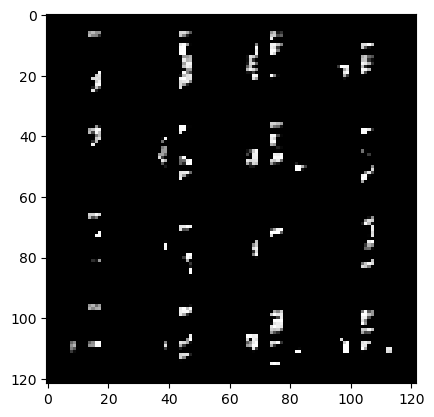

In [60]:
# create some samples from random noise and show them
samples = model3.generate(16)
show_img(samples)

In [42]:
# create model and train
model4 = VAE(emb_dim=2)
model4.fit(train_ds, lr=0.00001)

running on cuda:0.
starting training...
00:00:13 - Epoch: 1/101, loss: -1476303.314036
00:00:27 - Epoch: 2/101, loss: -1758698.581000
00:00:40 - Epoch: 3/101, loss: -1797232.372333
00:00:54 - Epoch: 4/101, loss: -1810992.603067
00:01:07 - Epoch: 5/101, loss: -1801795.601000
00:01:20 - Epoch: 6/101, loss: -1551762.949000
00:01:34 - Epoch: 7/101, loss: -1194438.676467
00:01:47 - Epoch: 8/101, loss: -1182295.660500
00:02:00 - Epoch: 9/101, loss: -1209280.316133
00:02:13 - Epoch: 10/101, loss: -1233906.295067
00:02:27 - Epoch: 11/101, loss: -1256118.164933
00:02:40 - Epoch: 12/101, loss: -1278195.250733
00:02:52 - Epoch: 13/101, loss: -1298783.909067
00:03:05 - Epoch: 14/101, loss: -1319215.737400
00:03:19 - Epoch: 15/101, loss: -1338250.669000
00:03:32 - Epoch: 16/101, loss: -1355410.130933
00:03:45 - Epoch: 17/101, loss: -1366417.985867
00:03:57 - Epoch: 18/101, loss: -1373470.298133
00:04:11 - Epoch: 19/101, loss: -1353974.875733
00:04:24 - Epoch: 20/101, loss: -1306590.844400
00:04:37 

Text(0.5, 1.0, '100 epochs')

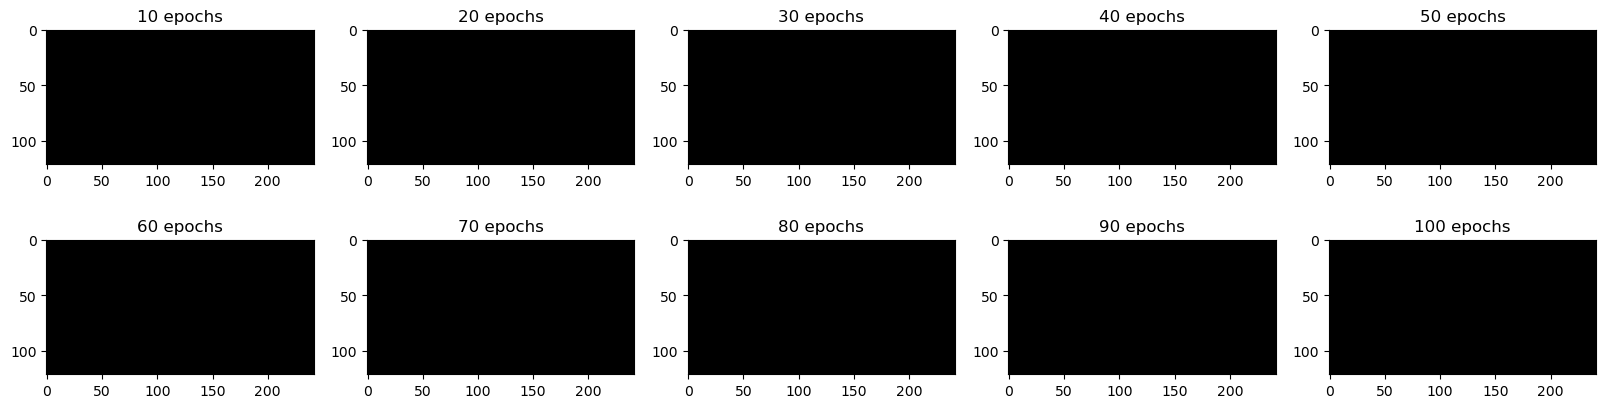

In [61]:
path = "samples/VAE/run_2023-07-13_21-26-42/"
#im_0 = img.imread(path+"image_eps0.png")
im_1 = img.imread(path+"image_eps10.png")
im_2 = img.imread(path+"image_eps20.png")
im_3 = img.imread(path+"image_eps30.png")
im_4 = img.imread(path+"image_eps40.png")
im_5 = img.imread(path+"image_eps50.png")
im_6 = img.imread(path+"image_eps60.png")
im_7 = img.imread(path+"image_eps70.png")
im_8 = img.imread(path+"image_eps80.png")
im_9 = img.imread(path+"image_eps90.png")
im_10 = img.imread(path+"image_eps100.png")


fig, axs = plt.subplots(2, 5, figsize=(20,5))
axs[0,0].imshow(im_1)
axs[0,0].set_title('10 epochs')

axs[0,1].imshow(im_2)
axs[0,1].set_title('20 epochs')

axs[0,2].imshow(im_3)
axs[0,2].set_title('30 epochs')

axs[0,3].imshow(im_4)
axs[0,3].set_title('40 epochs')

axs[0,4].imshow(im_5)
axs[0,4].set_title('50 epochs')

axs[1,0].imshow(im_6)
axs[1,0].set_title('60 epochs')

axs[1,1].imshow(im_7)
axs[1,1].set_title('70 epochs')

axs[1,2].imshow(im_8)
axs[1,2].set_title('80 epochs')

axs[1,3].imshow(im_9)
axs[1,3].set_title('90 epochs')

axs[1,4].imshow(im_10)
axs[1,4].set_title('100 epochs')

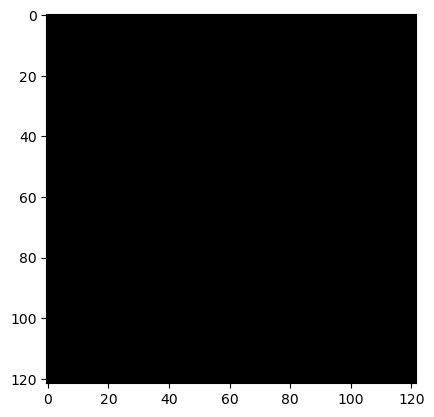

In [43]:
# create some samples from random noise and show them
samples = model4.generate(16)
show_img(samples)